In [106]:
import tsfresh
%matplotlib inline
import pandas as pd
import os

# Load Data
1) Determine Column names. In total there are 2 columns regarding index ('unit_nr') and time ('time_cycles'). There are three different setting values ('setting_1', 'setting_2' and 'setting_3'). Finally, there are 22 different sensors, each having their own column. 
2) Given the path to the data directory and the names of the files, the data is loaded into a single dataframe. The index column 'unit_nr' is adapted to also consider that units are from different files. 

In [107]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

In [108]:
directory = '../Data.nosync+/'
#TODO: Select files
#files = ['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']
files = ['test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt']

dataframes = []

for index, data in enumerate(files):
    file_path = os.path.join(directory, data)
    df = pd.read_csv(file_path, sep='\s+', header=None, names=col_names)
    df['unit_nr']=df['unit_nr'].apply(lambda x: str(index) + '_' + str(x))
    dataframes.append(df)

train = pd.concat(dataframes, ignore_index=True)
id_mapping = {id: str(idx + 1) for idx, id in enumerate(train['unit_nr'].unique())}

# Map the 'id' column using the mapping
train['unit_nr'] = train['unit_nr'].map(id_mapping)
train['unit_nr'] = pd.to_numeric(train['unit_nr'], errors='coerce')

# Preprocessing

In [109]:
def add_remaining_useful_life(df):
    '''
    Calculates the RUL of a dataframe and returns the dataframe with an added RUL column
    :param df: Dataframe for which RUL is to be calculated
    :return: df with RUL-column
    '''
    grouped_by_unit = df.groupby(by = "unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    remaining_useful_life = result_frame['max_cycle'] - result_frame['time_cycles']
    result_frame["RUL"] = remaining_useful_life
    result_frame = result_frame.drop("max_cycle", axis = 1)
    
    return result_frame

## Normalization

In [110]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_scale = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_15', 's_17', 's_20', 's_21', 's_1', 's_5', 's_6', 's_10', 's_14', 's_16', 's_18', 's_19']
for column in columns_to_scale:
    train[column] = scaler.fit_transform(train[[column]])

## Deal with NA values

In [111]:
train = train.fillna(method='ffill')
print(train.shape, "There are no NA values: ", (train.isna().sum()==0).all())

(104897, 26) There are no NA values:  True


In [112]:
cols_to_drop = ['setting_3', 's_1', 's_5', 's_6', 's_10', 's_14', 's_16', 's_18', 's_19']
train = train.drop(cols_to_drop, axis=1)

# Roll Dataset

In [113]:
from tsfresh.utilities.dataframe_functions import roll_time_series
df_rolled = roll_time_series(train, column_id="unit_nr", column_sort="time_cycles", min_timeshift=10, max_timeshift=90, rolling_direction=40)

Rolling: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]


In [114]:
df_rolled

,unit_nr,time_cycles,setting_1,setting_2,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_15,s_17,s_20,s_21,id
59969,2,1,-0.0009,0.0004,0.984758,0.944705,0.934119,0.962989,0.999050,0.883095,0.930612,0.963315,0.994975,0.081321,0.937500,0.974636,0.974202,"(2, 46)"
59970,2,2,-0.0011,0.0002,0.983381,0.942346,0.929989,0.963889,0.998987,0.894473,0.932245,0.964294,0.994810,0.085946,0.947917,0.969226,0.968443,"(2, 46)"
59971,2,3,0.0002,0.0003,0.984024,0.961790,0.943160,0.963450,0.999113,0.880051,0.932245,0.962507,0.994810,0.064407,0.958333,0.975313,0.974998,"(2, 46)"
59972,2,4,0.0025,0.0001,0.981544,0.928786,0.936733,0.965321,0.999134,0.888847,0.929796,0.963192,0.994755,0.083404,0.947917,0.968549,0.978580,"(2, 46)"
59973,2,5,0.0004,-0.0004,0.985768,0.933125,0.935194,0.964928,0.999113,0.886248,0.933878,0.963241,0.994893,0.080049,0.937500,0.968211,0.974045,"(2, 46)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155689,707,242,0.0025,0.0000,0.985952,0.928515,0.958433,0.963727,0.999092,0.910464,0.951020,0.962531,0.994810,0.093326,0.947917,0.960771,0.970248,"(707, 246)"
155690,707,243,25.0072,0.6200,0.013589,0.067363,0.067299,0.089562,0.001267,0.027855,0.062857,0.087770,0.001960,0.956886,0.041667,0.135610,0.139712,"(707, 246)"
155691,707,244,42.0027,0.8400,0.130934,0.328922,0.237940,0.006534,0.627531,0.297110,0.502041,0.004971,0.995196,0.409675,0.312500,0.015556,0.016597,"(707, 246)"
155692,707,245,0.0028,0.0000,0.989349,0.966644,0.943014,0.964489,0.998965,0.912870,0.943673,0.962507,0.994837,0.086758,0.947917,0.965506,0.972403,"(707, 246)"


## Add RUL

In [115]:
import numpy as np


def add_max_rul(df):
    helper = df.groupby(by = "unit_nr")["RUL"].transform("max")
    df["RUL_max"] = helper
    return df

def create_rul_perc(df):
    df["RUL_perc"] = df["RUL"]/df["RUL_max"]
    df["RUL_perc_2"] = df.groupby(by = "id")["RUL_perc"].transform("min")
    #df['RUL_perc'] = np.where(df['RUL'] == 0, 0, df['RUL'] / df['RUL_max'])
    return df

def create_rul_class(df):
    df["Class"] = pd.cut(x=df["RUL_perc_2"], bins=[-1, 0.1, 
                                                      0.3, 
                                                      0.5, 
                                                      1], labels=[0,1,2,3])
    return df

In [116]:
import math

df_rolled = add_remaining_useful_life(df_rolled)
df_rolled = add_max_rul(df_rolled)
df_rolled = create_rul_perc(df_rolled)
df_rolled = create_rul_class(df_rolled)
#df_rolled = df_rolled.drop(columns=["RUL_max", "RUL_perc"])

In [117]:
#df_rolled["Class"] = pd.cut(x=df_rolled["RUL"], bins=[-1, math.floor(0.1*max(df_rolled["RUL"])), math.floor(0.3*max(df_rolled["RUL"])), math.floor(0.5*max(df_rolled["RUL"])), max(df_rolled["RUL"])], labels=[0,1,2,3])

#grouped_by_unit = df_rolled.groupby(by = "id")
#max_RUL = grouped_by_unit["RUL"].min()
#result_frame = df_rolled.merge(max_RUL.to_frame(name='max_RUL'), left_on='id', right_index=True)

#result_frame

In [118]:
#result_frame["Class"] = pd.cut(x=result_frame["max_RUL"], bins=[-1, math.floor(0.1*max(df_rolled["RUL"])), math.floor(0.3*max(df_rolled["RUL"])), math.floor(0.5*max(df_rolled["RUL"])), max(df_rolled["RUL"])], labels=[0,1,2,3])

#result_frame.head(100)

In [119]:
#df_rolled = result_frame
#df_rolled["RUL"] = df_rolled["max_RUL"]
#df_rolled = df_rolled.drop(columns=["max_RUL"])

In [120]:
df_rolled

,unit_nr,time_cycles,setting_1,setting_2,s_2,s_3,s_4,s_7,s_8,s_9,...,s_15,s_17,s_20,s_21,id,RUL,RUL_max,RUL_perc,RUL_perc_2,Class
59969,2,1,-0.0009,0.0004,0.984758,0.944705,0.934119,0.962989,0.999050,0.883095,...,0.081321,0.937500,0.974636,0.974202,"(2, 46)",45,45,1.000000,0.0,0
59970,2,2,-0.0011,0.0002,0.983381,0.942346,0.929989,0.963889,0.998987,0.894473,...,0.085946,0.947917,0.969226,0.968443,"(2, 46)",44,45,0.977778,0.0,0
59971,2,3,0.0002,0.0003,0.984024,0.961790,0.943160,0.963450,0.999113,0.880051,...,0.064407,0.958333,0.975313,0.974998,"(2, 46)",43,45,0.955556,0.0,0
59972,2,4,0.0025,0.0001,0.981544,0.928786,0.936733,0.965321,0.999134,0.888847,...,0.083404,0.947917,0.968549,0.978580,"(2, 46)",42,45,0.933333,0.0,0
59973,2,5,0.0004,-0.0004,0.985768,0.933125,0.935194,0.964928,0.999113,0.886248,...,0.080049,0.937500,0.968211,0.974045,"(2, 46)",41,45,0.911111,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155689,707,242,0.0025,0.0000,0.985952,0.928515,0.958433,0.963727,0.999092,0.910464,...,0.093326,0.947917,0.960771,0.970248,"(707, 246)",4,245,0.016327,0.0,0
155690,707,243,25.0072,0.6200,0.013589,0.067363,0.067299,0.089562,0.001267,0.027855,...,0.956886,0.041667,0.135610,0.139712,"(707, 246)",3,245,0.012245,0.0,0
155691,707,244,42.0027,0.8400,0.130934,0.328922,0.237940,0.006534,0.627531,0.297110,...,0.409675,0.312500,0.015556,0.016597,"(707, 246)",2,245,0.008163,0.0,0
155692,707,245,0.0028,0.0000,0.989349,0.966644,0.943014,0.964489,0.998965,0.912870,...,0.086758,0.947917,0.965506,0.972403,"(707, 246)",1,245,0.004082,0.0,0


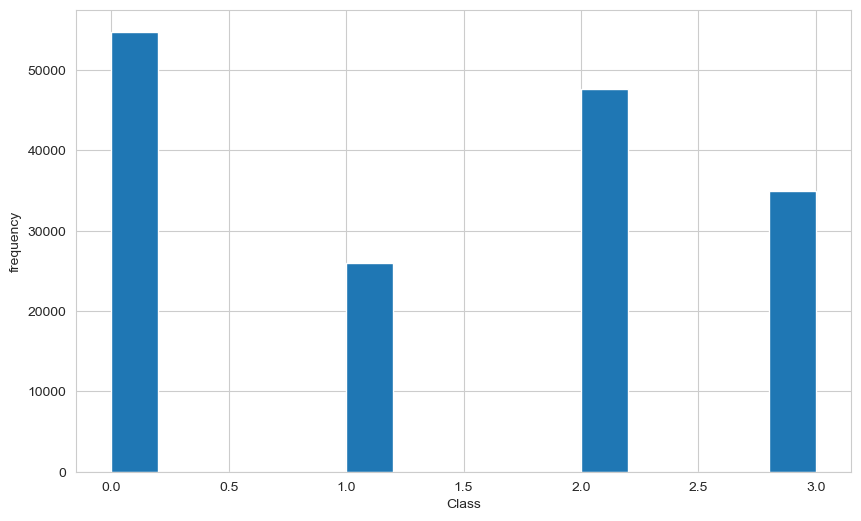

In [121]:
import matplotlib.pyplot as plt
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = df_rolled[['unit_nr', 'Class']]
df_max_rul['Class'].hist(bins=15, figsize=(10,6))
plt.xlabel('Class')
plt.ylabel('frequency')
plt.show()

# Create Features

In [122]:
from tsfresh import extract_features
#id_mapping = {id: str(idx + 1) for idx, id in enumerate(train['unit_nr'].unique())}

# Map the 'id' column using the mapping
#train['unit_nr'] = train['unit_nr'].map(id_mapping)
#train['unit_nr'] = pd.to_numeric(train['unit_nr'], errors='coerce')
y = df_rolled["Class"]
y_distinct = df_rolled.groupby('id')['Class'].first()

y = df_rolled.set_index('id')['Class']
X = df_rolled.drop(columns=["RUL", "Class", "setting_1", "setting_2"])

In [123]:
y_distinct

id
(2, 46)       0
(3, 46)       3
(3, 86)       2
(3, 126)      0
(4, 46)       2
             ..
(707, 86)     3
(707, 126)    2
(707, 166)    2
(707, 206)    1
(707, 246)    0
Name: Class, Length: 2153, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]

In [124]:
print(y_distinct.shape, "There are no NA values: ", (y_distinct.isna().sum()==0).all())

(2153,) There are no NA values:  True


In [125]:
X.dtypes

unit_nr          int64
time_cycles      int64
s_2            float64
s_3            float64
s_4            float64
s_7            float64
s_8            float64
s_9            float64
s_11           float64
s_12           float64
s_13           float64
s_15           float64
s_17           float64
s_20           float64
s_21           float64
id              object
RUL_max          int64
RUL_perc       float64
RUL_perc_2     float64
dtype: object

In [126]:
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters

# TODO: select how to extract features
X_rel = pd.read_parquet('turbofan_features.parquet', engine='pyarrow')
kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(X_rel)
X_rel = extract_features(X, column_id='id', column_sort='time_cycles', kind_to_fc_parameters=kind_to_fc_parameters)

#X_rel = extract_relevant_features(X, y=y_distinct, ml_task='classification', column_id='id', column_sort='time_cycles',default_fc_parameters=MinimalFCParameters() ,fdr_level=0.001)

Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


In [127]:
 X_rel.isna().sum().sum()


0

In [128]:
X_rel.describe()

,unit_nr__length,unit_nr__sum_values,s_2__length,s_2__sum_values,s_2__maximum,s_2__absolute_maximum,s_2__median,s_2__standard_deviation,s_2__variance,s_2__root_mean_square,...,RUL_perc_2__minimum,RUL_perc_2__absolute_maximum,RUL_perc_2__median,RUL_perc_2__maximum,RUL_perc_2__root_mean_square,RUL_perc_2__variance,RUL_perc_2__standard_deviation,RUL_perc_2__length,RUL_perc_2__mean,RUL_perc_2__sum_values
count,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,...,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2.153000e+03,2.153000e+03,2153.000000,2153.000000,2153.000000
mean,75.865304,28976.011147,75.865304,42.886977,0.986738,0.986738,0.465583,0.243371,0.082464,0.655809,...,0.335427,0.335427,0.335427,0.335427,0.335427,8.417199e-33,4.994199e-17,75.865304,0.335427,22.607298
std,20.048280,17903.851469,20.048280,23.393872,0.003177,0.003177,0.353301,0.152464,0.052905,0.207649,...,0.278908,0.278908,0.278908,0.278908,0.278908,2.110700e-32,7.697889e-17,20.048280,0.278908,17.992512
min,46.000000,92.000000,46.000000,12.735286,0.978147,0.978147,0.128317,0.001873,0.000004,0.388360,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,46.000000,0.000000,0.000000
25%,46.000000,13662.000000,46.000000,31.003214,0.984483,0.984483,0.183822,0.003126,0.000010,0.512074,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,46.000000,0.000000,0.000000
50%,86.000000,27002.000000,86.000000,36.332201,0.986686,0.986686,0.188321,0.331318,0.109772,0.544174,...,0.320000,0.320000,0.320000,0.320000,0.320000,0.000000e+00,0.000000e+00,86.000000,0.320000,25.543860
75%,91.000000,44204.000000,91.000000,45.089248,0.988890,0.988890,0.978606,0.345202,0.119165,0.978706,...,0.585366,0.585366,0.585366,0.585366,0.585366,1.232595e-32,1.110223e-16,91.000000,0.585366,35.512195
max,91.000000,64337.000000,91.000000,89.886145,0.999816,0.999816,0.988064,0.397787,0.158234,0.987765,...,0.907216,0.907216,0.907216,0.907216,0.907216,1.972152e-31,4.440892e-16,91.000000,0.907216,70.927835


In [129]:
# TODO: Add/Remove test to name
X_rel.to_parquet('turbofan_features_test.parquet', engine='pyarrow')
df = pd.DataFrame({'my_series': y_distinct})
df.to_parquet('turbofan_RUL_test.parquet', engine='pyarrow')

In [130]:
y_distinct.min()

0

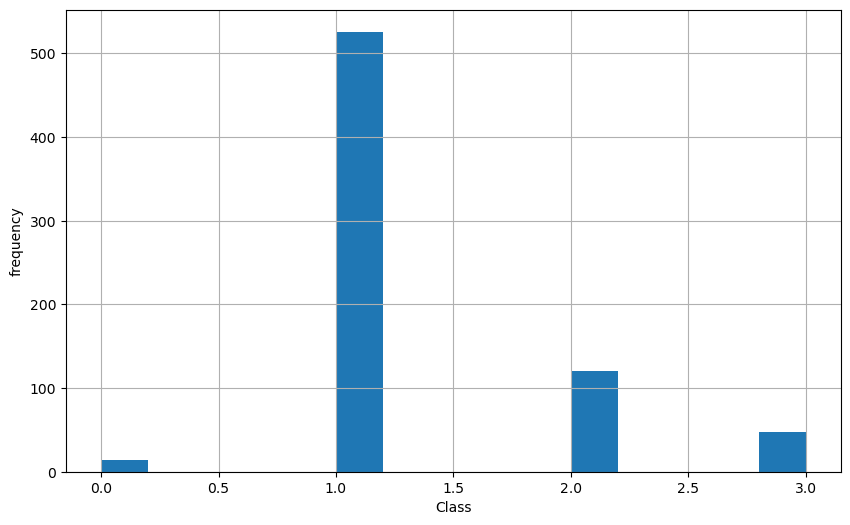